Анализ изображений и видео, 2

Лабораторная работа №4.

Гронский Дмитрий, CS

In [1]:
%pylab inline
import skimage.io as io
import glob
import os
import numpy as np

Populating the interactive namespace from numpy and matplotlib


## Наивная сегментация

In [2]:
def read_dataset(folder):
    train_images = []
    train_gt = []
    test_images = []
    test_gt = []
    gt_files = glob.glob(os.path.join(folder, "GroundTruth", "*bmp"))
    for gt in gt_files:
        img = io.imread(gt)
        if int(gt.split("_")[1]) > 15:
            test_gt.append(img)
        else:
            train_gt.append(img)
            
    images_files = glob.glob(os.path.join(folder, "Images", "*bmp"))
    for image_file in images_files:
        img = io.imread(image_file)
        if int(image_file.split("_")[1]) > 15:
            test_images.append(img)
        else:
            train_images.append(img)
            
    return test_gt, train_gt, test_images, train_images

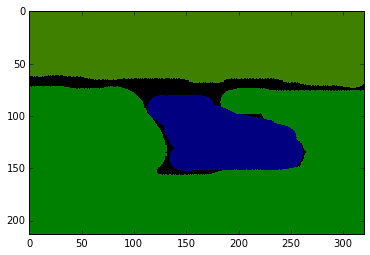

In [3]:
test_gt, train_gt, test_images, train_images = read_dataset(".")
io.imshow(test_gt[0])
io.show()

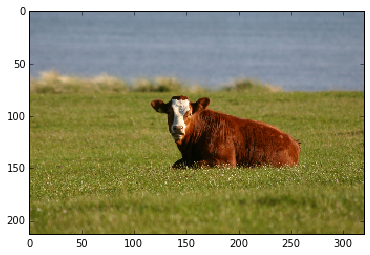

In [4]:
io.imshow(test_images[0])
io.show()

In [5]:
background_color = [0, 128, 0]
cow_color = [0, 0, 128]
ship_color = [0, 128, 128]

X_train = np.empty((0,3), int)
Y_train = np.empty((0,1), int)

for img, gt in zip(train_images, train_gt):
    #print img.shape
    x = numpy.reshape(img, (img.shape[0] * img.shape[1], 3))
    gt = numpy.reshape(gt, (img.shape[0] * img.shape[1], 3))
    y = numpy.zeros(img.shape[0] * img.shape[1], int)
    
    #give labels
    cowidx = ((gt[:, 0] == cow_color[0] ) * (gt[:, 1] == cow_color[1]) * (gt[:, 2] == cow_color[2]))
    shipidx = ((gt[:, 0] == ship_color[0] ) * (gt[:, 1] == ship_color[1]) * (gt[:, 2] == ship_color[2]))
    bidx = ((gt[:, 0] == background_color[0] ) * (gt[:, 1] == background_color[1]) * (gt[:, 2] == background_color[2]))

    y[cowidx] = 1
    y[shipidx] = 2
    y[bidx] = 3
    
    #remove unknown data
    x = x[y!=0, :]
    y = y[y!=0]
    
    X_train = np.vstack((X_train, x))
    Y_train = np.append(Y_train, y)

In [6]:
X_test = np.empty((0,3), int)
Y_test = np.empty((0,1), int)

for img, gt in zip(test_images, test_gt):
    #print img.shape
    x = numpy.reshape(img, (img.shape[0] * img.shape[1], 3))
    gt = numpy.reshape(gt, (img.shape[0] * img.shape[1], 3))
    y = numpy.zeros(img.shape[0] * img.shape[1], int)
    
    #give labels
    cowidx = ((gt[:, 0] == cow_color[0] ) * (gt[:, 1] == cow_color[1]) * (gt[:, 2] == cow_color[2]))
    shipidx = ((gt[:, 0] == ship_color[0] ) * (gt[:, 1] == ship_color[1]) * (gt[:, 2] == ship_color[2]))
    bidx = ((gt[:, 0] == background_color[0] ) * (gt[:, 1] == background_color[1]) * (gt[:, 2] == background_color[2]))

    y[cowidx] = 1
    y[shipidx] = 2
    y[bidx] = 3
    
    #remove unknown data
    x = x[y!=0, :]
    y = y[y!=0]
    
    X_test = numpy.vstack((X_test, x))
    Y_test = numpy.append(Y_test, y)


In [7]:
rp = numpy.random.permutation(len(X_train))
X_train = X_train[rp]
Y_train = Y_train[rp]

from sklearn import svm
clf = svm.SVC()
clf.fit(X_train[:10000,:], Y_train[:10000,])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [8]:
#test on small part
rp = numpy.random.permutation(len(X_test))
X_test = X_test[rp]
Y_test = Y_test[rp]
Y_pred_small = clf.predict(X_test[:10000,:])
import sklearn.metrics
print 'Accuracy ', sklearn.metrics.accuracy_score(Y_test[:10000], Y_pred_small)

Accuracy  0.6996


### Выбор параметров классификатора

In [12]:
accuracy = []
for gamma in np.logspace(-3, 0, num=15):
    clf = svm.SVC(gamma=gamma)
    clf.fit(X_train[:10000,:], Y_train[:10000,])
    accuracy.append(clf.score(X_test[:10000, :], Y_test[:10000,]))
    print gamma

0.001
0.00163789370695
0.00268269579528
0.00439397056076
0.00719685673001
0.0117876863479
0.0193069772888
0.0316227766017
0.0517947467923
0.0848342898244
0.138949549437
0.227584592607
0.372759372031
0.610540229659
1.0


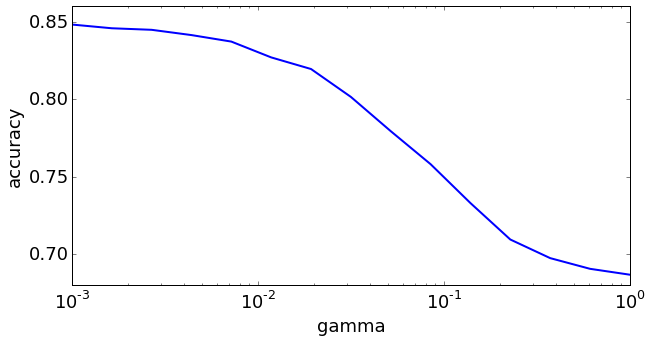

In [13]:
plt.figure(figsize=(10,5))
plt.semilogx(np.logspace(-3, 0, num=15), accuracy, 'b-', linewidth=2)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('gamma', fontsize=18)
plt.ylabel('accuracy', fontsize=18)

берем $\gamma = 0.001$

In [15]:
clf = svm.SVC(gamma=0.001)
clf.fit(X_train[:10000,:], Y_train[:10000,])
print 'score ', clf.score(X_test[:10000, :], Y_test[:10000,])

score  0.8482


### Визуализация результатов

In [18]:
from skimage.color import label2rgb
def segmentate_by_color (image, user_segmentation, classifier):
    X = np.reshape(image, (image.shape[0] * image.shape[1], 3))
    labels = classifier.predict(X)
    segmentation = labels.reshape((image.shape[0], image.shape[1]))
    plt.figure(figsize=(15,5))
    plt.subplot(131)
    io.imshow(image)
    plt.title('Origin', fontsize=20)
    plt.subplot(132)
    io.imshow(user_segmentation)
    plt.title('User segmentation', fontsize=20)
    plt.subplot(133)
    io.imshow(label2rgb(segmentation))
    plt.title('Algorithm segmentation', fontsize=20)
    io.show()

### На обучении

На сегментированных картинках фиолетовые области соответствуют фону, синие - коровам, желтые овцам.

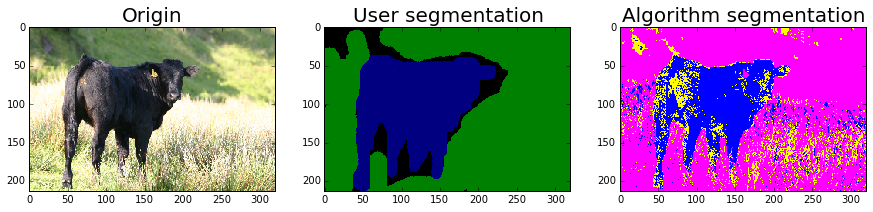

In [19]:
segmentate_by_color(train_images[0], train_gt[0], clf)

### На контроле

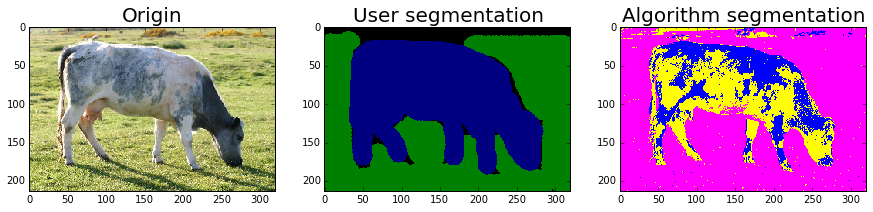

In [20]:
segmentate_by_color(test_images[5], test_gt[5], clf)

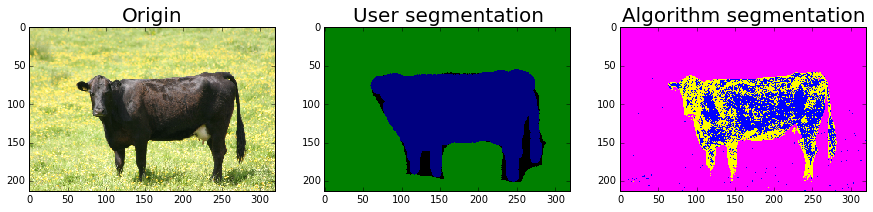

In [21]:
segmentate_by_color(test_images[7], test_gt[7], clf)

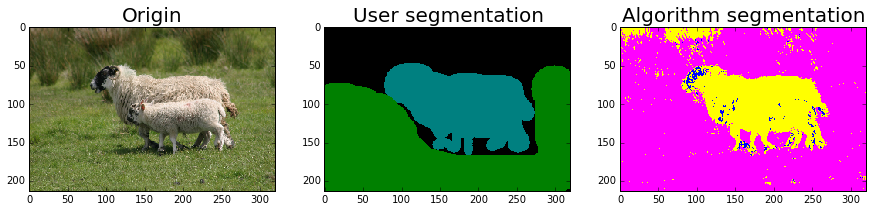

In [22]:
segmentate_by_color(test_images[16], test_gt[16], clf)

Фон выделяется нормально, корова и овца между собой разделябтся плохо

## Сегментация на основе среднего цвета суперпикселя

In [23]:
background_color = [0, 128, 0]
cow_color = [0, 0, 128]
ship_color = [0, 128, 128]

X_train = np.empty((0,3))
Y_train = np.empty(0, int)

n_superpixels = 10

from skimage.segmentation import slic

for img, gt in zip(train_images, train_gt):
    
    superpixels = slic(img, n_segments=n_superpixels, compactness=10.0, sigma=5, enforce_connectivity=False).reshape(img.shape[0] * 
                                                                                                                     img.shape[1])
    img_reshaped = np.reshape(img, (img.shape[0] * img.shape[1], 3))
    n_segments = superpixels.max() + 1
    x = numpy.zeros((n_segments, 3))
    
    for segment in xrange(n_segments):
        x[segment, :] = np.mean(img_reshaped[superpixels==segment, :], axis=0)
    
    
    gt = numpy.reshape(gt, (img.shape[0] * img.shape[1], 3))
    y = numpy.zeros(n_segments, int)
    
    #give labels
    cowidx = ((gt[:, 0] == cow_color[0] ) * (gt[:, 1] == cow_color[1]) * (gt[:, 2] == cow_color[2]))
    shipidx = ((gt[:, 0] == ship_color[0] ) * (gt[:, 1] == ship_color[1]) * (gt[:, 2] == ship_color[2]))
    bidx = ((gt[:, 0] == background_color[0] ) * (gt[:, 1] == background_color[1]) * (gt[:, 2] == background_color[2]))
    nanidx = np.logical_and(np.logical_and(cowidx==False, shipidx==False), bidx==False)
    
    idx = np.concatenate((np.expand_dims(nanidx, 1), np.expand_dims(cowidx, 1), np.expand_dims(shipidx, 1), np.expand_dims(bidx, 1)), 
                         axis=1)
    
    for segment in xrange(n_segments):
        labels_count = np.sum(idx[superpixels==segment, :], axis=0)
        y[segment] = np.argmax(labels_count)
    
    #remove unknown data
    x = x[y!=0, :]
    y = y[y!=0]
    
    X_train = np.vstack((X_train, x))
    Y_train = np.append(Y_train, y)

In [78]:
X_test = np.empty((0,3))
Y_test = np.empty(0, int)

for img, gt in zip(test_images, test_gt):
    
    superpixels = slic(img, n_segments=n_superpixels, compactness=10.0, sigma=5, enforce_connectivity=False).reshape(img.shape[0] * 
                                                                                                                     img.shape[1])
    img_reshaped = np.reshape(img, (img.shape[0] * img.shape[1], 3))
    n_segments = superpixels.max() + 1
    x = numpy.zeros((n_segments, 3))
    
    for segment in xrange(n_segments):
        x[segment, :] = np.mean(img_reshaped[superpixels==segment, :], axis=0)
    
    
    gt = numpy.reshape(gt, (img.shape[0] * img.shape[1], 3))
    y = numpy.zeros(n_segments, int)
    
    #give labels
    cowidx = ((gt[:, 0] == cow_color[0] ) * (gt[:, 1] == cow_color[1]) * (gt[:, 2] == cow_color[2]))
    shipidx = ((gt[:, 0] == ship_color[0] ) * (gt[:, 1] == ship_color[1]) * (gt[:, 2] == ship_color[2]))
    bidx = ((gt[:, 0] == background_color[0] ) * (gt[:, 1] == background_color[1]) * (gt[:, 2] == background_color[2]))
    nanidx = np.logical_and(np.logical_and(cowidx==False, shipidx==False), bidx==False)
    
    idx = np.concatenate((np.expand_dims(nanidx, 1), np.expand_dims(cowidx, 1), np.expand_dims(shipidx, 1), np.expand_dims(bidx, 1)), 
                         axis=1)
    
    for segment in xrange(n_segments):
        labels_count = np.sum(idx[superpixels==segment, :], axis=0)
        y[segment] = np.argmax(labels_count)
    
    #remove unknown data
    x = x[y!=0, :]
    y = y[y!=0]
    
    X_test = np.vstack((X_test, x))
    Y_test = np.append(Y_test, y)

### Выбор параметров классификатора

In [79]:
accuracy = []
for gamma in np.logspace(-4, 0, num=20):
    clf_slic = svm.SVC(gamma=gamma)
    clf_slic.fit(X_train, Y_train)
    accuracy.append(clf_slic.score(X_test, Y_test))
    print gamma

0.0001
0.000162377673919
0.000263665089873
0.000428133239872
0.000695192796178
0.00112883789168
0.00183298071083
0.00297635144163
0.00483293023857
0.00784759970351
0.012742749857
0.0206913808111
0.0335981828628
0.0545559478117
0.088586679041
0.143844988829
0.233572146909
0.379269019073
0.615848211066
1.0


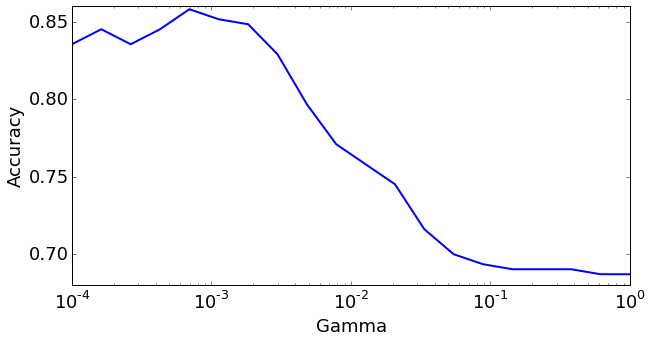

In [80]:
plt.figure(figsize=(10,5))
plt.semilogx(np.logspace(-4, 0, num=20), accuracy, 'b-', linewidth=2)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Gamma', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)

Выбираем $\gamma = 0.0007$.

In [81]:
clf_slic = svm.SVC(gamma=0.0007)
clf_slic.fit(X_train, Y_train)
print 'score ', clf_slic.score(X_test, Y_test), 'with gamma=0.0007'

score  0.858064516129 with gamma=0.0007


Примерно также, как и для классификации пикселей по цвету. Но это доля правильно отклассифицированных суперпикселей. Смотрим, что получается при визуализации.

### Визуализация

In [28]:
from skimage.color import label2rgb
from skimage.segmentation import mark_boundaries

In [64]:
def segmentate_by_superpixel_color (image, user_segmentation, classifier, n_superpixels):

    superpixels = slic(image, n_segments=n_superpixels, compactness=10.0, sigma=5, enforce_connectivity=False)
    superpixels_reshaped = superpixels.reshape(image.shape[0] * image.shape[1])
    image_reshaped = np.reshape(image, (image.shape[0] * image.shape[1], 3))
    X = numpy.zeros((image.shape[0] * image.shape[1], 3))
    
    n_segments = superpixels.max() + 1
    for segment in xrange(n_segments):
        X[superpixels_reshaped==segment, :] = np.mean(image_reshaped[superpixels_reshaped==segment, :], axis=0)
    
    labels = classifier.predict(X)
    segmentation = labels.reshape((image.shape[0], image.shape[1]))
    
    plt.figure(figsize=(20,7))
    plt.subplot(141)
    io.imshow(image)
    plt.title('Origin', fontsize=20)
    plt.subplot(142)
    io.imshow(mark_boundaries(image, superpixels))
    plt.title('Slic', fontsize=20)
    plt.subplot(143)
    io.imshow(user_segmentation)
    plt.title('User segmentation', fontsize=20)
    plt.subplot(144)
    io.imshow(label2rgb(segmentation))
    plt.title('Algorithm segmentation', fontsize=20)
    io.show()

(310L, 3L) (12L, 3L)
0


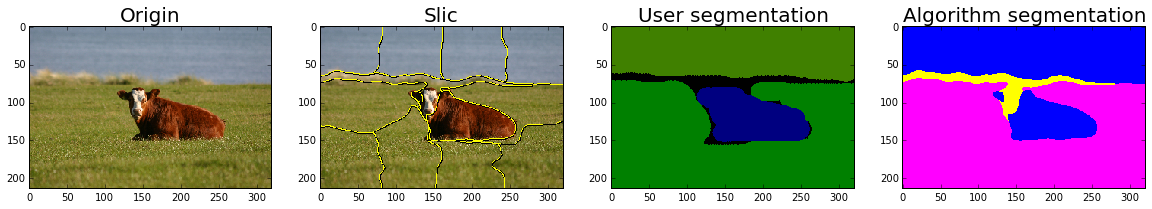

In [82]:
segmentate_by_superpixel_color(test_images[0], test_gt[0], clf_slic, n_superpixels)

(310L, 3L) (12L, 3L)
0


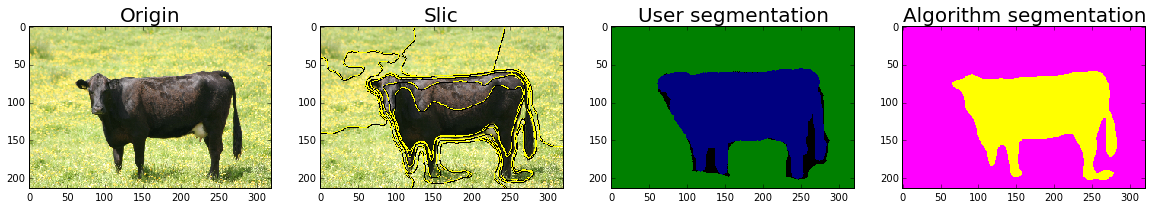

In [83]:
segmentate_by_superpixel_color(test_images[7], test_gt[7], clf_slic, n_superpixels)

(310L, 3L) (12L, 3L)
0


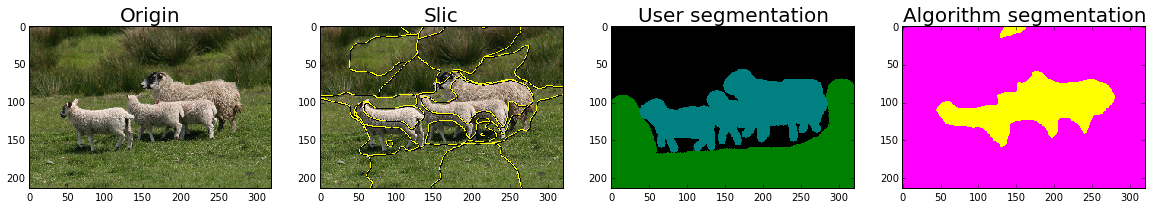

In [84]:
segmentate_by_superpixel_color(test_images[17], test_gt[17], clf_slic, n_superpixels)

(310L, 3L) (12L, 3L)
0


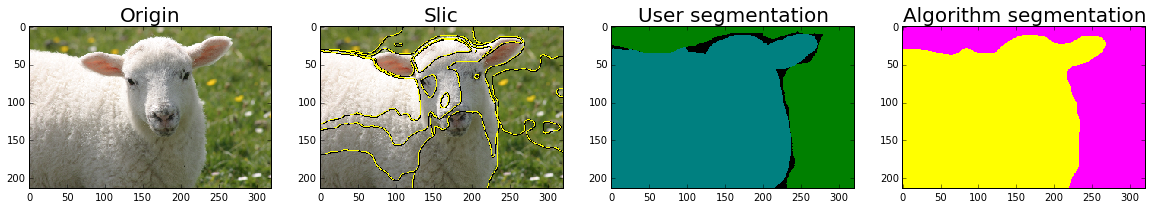

In [85]:
segmentate_by_superpixel_color(test_images[-1], test_gt[-1], clf_slic, n_superpixels)

Згачительно менее шумная сегментация. Коровы все так же потаются с овцами

## Добавление дескриптора

Добавим в признаковое пространство sift декстриптор (теперь размерность 131) локальной особенности суперпикселя

In [125]:
from cv2 import SIFT
from skimage.color import rgb2gray

In [144]:
background_color = [0, 128, 0]
cow_color = [0, 0, 128]
ship_color = [0, 128, 128]

X_train = np.empty((0,3 + 128))
Y_train = np.empty(0, int)

n_superpixels = 20
sift = SIFT(1)

from skimage.segmentation import slic

for img, gt in zip(train_images, train_gt):
    
    superpixels = slic(img, n_segments=n_superpixels, compactness=10.0, sigma=5, enforce_connectivity=False)
    superpixels_reshaped = superpixels.reshape(img.shape[0] * img.shape[1])
    img_reshaped = np.reshape(img, (img.shape[0] * img.shape[1], 3))
    n_segments = superpixels.max() + 1
    x = numpy.zeros((n_segments, 3 + 128))
    
    img_gray = rgb2gray(img) * 255
    img_gray = img_gray.astype(uint8)
    
    for segment in xrange(n_segments):
        x[segment, :3] = np.mean(img_reshaped[superpixels_reshaped==segment, :], axis=0)
        mask = superpixels==segment
        keypoints, descriptors = sift.detectAndCompute(img_gray, mask.astype(uint8))
        if len(keypoints) > 0:
            x[segment, 3:] = descriptors[0, :]
    
    
    gt = numpy.reshape(gt, (img.shape[0] * img.shape[1], 3))
    y = numpy.zeros(n_segments, int)
    
    #give labels
    cowidx = ((gt[:, 0] == cow_color[0] ) * (gt[:, 1] == cow_color[1]) * (gt[:, 2] == cow_color[2]))
    shipidx = ((gt[:, 0] == ship_color[0] ) * (gt[:, 1] == ship_color[1]) * (gt[:, 2] == ship_color[2]))
    bidx = ((gt[:, 0] == background_color[0] ) * (gt[:, 1] == background_color[1]) * (gt[:, 2] == background_color[2]))
    nanidx = np.logical_and(np.logical_and(cowidx==False, shipidx==False), bidx==False)
    
    idx = np.concatenate((np.expand_dims(nanidx, 1), np.expand_dims(cowidx, 1), np.expand_dims(shipidx, 1), np.expand_dims(bidx, 1)), 
                         axis=1)
    
    for segment in xrange(n_segments):
        labels_count = np.sum(idx[superpixels_reshaped==segment, :], axis=0)
        y[segment] = np.argmax(labels_count)
    
    #remove unknown data
    x = x[y!=0, :]
    y = y[y!=0]
    
    X_train = np.vstack((X_train, x))
    Y_train = np.append(Y_train, y)

In [145]:
X_test = np.empty((0,3 + 128))
Y_test = np.empty(0, int)

n_superpixels = 10
sift = SIFT(1)

from skimage.segmentation import slic

for img, gt in zip(test_images, test_gt):
    
    superpixels = slic(img, n_segments=n_superpixels, compactness=10.0, sigma=5, enforce_connectivity=False)
    superpixels_reshaped = superpixels.reshape(img.shape[0] * img.shape[1])
    img_reshaped = np.reshape(img, (img.shape[0] * img.shape[1], 3))
    n_segments = superpixels.max() + 1
    x = numpy.zeros((n_segments, 3 + 128))
    
    img_gray = rgb2gray(img) * 255
    img_gray = img_gray.astype(uint8)
    
    for segment in xrange(n_segments):
        x[segment, :3] = np.mean(img_reshaped[superpixels_reshaped==segment, :], axis=0)
        mask = superpixels==segment
        keypoints, descriptors = sift.detectAndCompute(img_gray, mask.astype(uint8))
        if len(keypoints) > 0:
            x[segment, 3:] = descriptors[0, :]
    
    
    gt = numpy.reshape(gt, (img.shape[0] * img.shape[1], 3))
    y = numpy.zeros(n_segments, int)
    
    #give labels
    cowidx = ((gt[:, 0] == cow_color[0] ) * (gt[:, 1] == cow_color[1]) * (gt[:, 2] == cow_color[2]))
    shipidx = ((gt[:, 0] == ship_color[0] ) * (gt[:, 1] == ship_color[1]) * (gt[:, 2] == ship_color[2]))
    bidx = ((gt[:, 0] == background_color[0] ) * (gt[:, 1] == background_color[1]) * (gt[:, 2] == background_color[2]))
    nanidx = np.logical_and(np.logical_and(cowidx==False, shipidx==False), bidx==False)
    
    idx = np.concatenate((np.expand_dims(nanidx, 1), np.expand_dims(cowidx, 1), np.expand_dims(shipidx, 1), np.expand_dims(bidx, 1)), 
                         axis=1)
    
    for segment in xrange(n_segments):
        labels_count = np.sum(idx[superpixels_reshaped==segment, :], axis=0)
        y[segment] = np.argmax(labels_count)
    
    #remove unknown data
    x = x[y!=0, :]
    y = y[y!=0]
    
    X_test = np.vstack((X_test, x))
    Y_test = np.append(Y_test, y)

### Выбор параметров

In [146]:
accuracy = []
for gamma in np.logspace(-4, 0, num=20):
    clf_slic_sift = svm.SVC(gamma=gamma)
    clf_slic_sift.fit(X_train, Y_train)
    accuracy.append(clf_slic_sift.score(X_test, Y_test))
    print gamma

0.0001
0.000162377673919
0.000263665089873
0.000428133239872
0.000695192796178
0.00112883789168
0.00183298071083
0.00297635144163
0.00483293023857
0.00784759970351
0.012742749857
0.0206913808111
0.0335981828628
0.0545559478117
0.088586679041
0.143844988829
0.233572146909
0.379269019073
0.615848211066
1.0


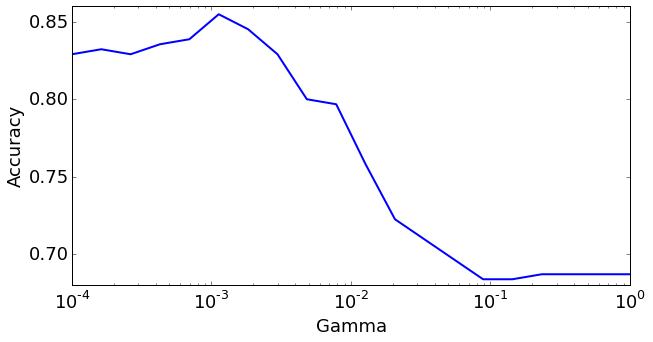

In [147]:
plt.figure(figsize=(10,5))
plt.semilogx(np.logspace(-4, 0, num=20), accuracy, 'b-', linewidth=2)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Gamma', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)

Выбираем $\gamma = 0.0011$.

In [151]:
clf_slic_sift = svm.SVC(gamma=0.0011)
clf_slic_sift.fit(X_train, Y_train)
print 'score ', clf_slic_sift.score(X_test, Y_test), 'with gamma=0.0011'

score  0.854838709677 with gamma=0.0011


### Визуализация

In [134]:
def segmentate_by_superpixel_color_sift (image, user_segmentation, classifier, n_superpixels):

    superpixels = slic(image, n_segments=n_superpixels, compactness=10.0, sigma=5, enforce_connectivity=False)
    superpixels_reshaped = superpixels.reshape(image.shape[0] * image.shape[1])
    image_reshaped = np.reshape(image, (image.shape[0] * image.shape[1], 3))
    
    n_segments = superpixels.max() + 1
    X = numpy.zeros((n_segments, 3 + 128))
    
    image_gray = rgb2gray(image) * 255
    image_gray = image_gray.astype(uint8)
        
    for segment in xrange(n_segments):
        X[segment, :3] = np.mean(image_reshaped[superpixels_reshaped==segment, :], axis=0)
        mask = superpixels==segment
        keypoints, descriptors = sift.detectAndCompute(image_gray, mask.astype(uint8))
        if len(keypoints) > 0:
            X[segment, 3:] = descriptors[0, :]
    
    labels = classifier.predict(X)
    segmentation = np.zeros((image.shape[0], image.shape[1]), int)
    for segment in xrange(n_segments):
        segmentation[superpixels==segment] = labels[segment]
    
    plt.figure(figsize=(20,7))
    plt.subplot(141)
    io.imshow(image)
    plt.title('Origin', fontsize=20)
    plt.subplot(142)
    io.imshow(mark_boundaries(image, superpixels))
    plt.title('Slic', fontsize=20)
    plt.subplot(143)
    io.imshow(user_segmentation)
    plt.title('User segmentation', fontsize=20)
    plt.subplot(144)
    io.imshow(label2rgb(segmentation))
    plt.title('Algorithm segmentation', fontsize=20)
    io.show()

[1 1 1 1 3 2 1 3 3 3 3 3]


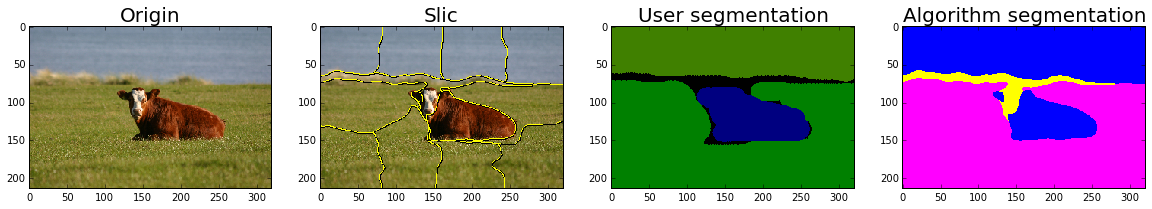

In [152]:
segmentate_by_superpixel_color_sift(test_images[0], test_gt[0], clf_slic_sift, n_superpixels)

[3 3 1 3 3 2 1 3 3 3 3 3]


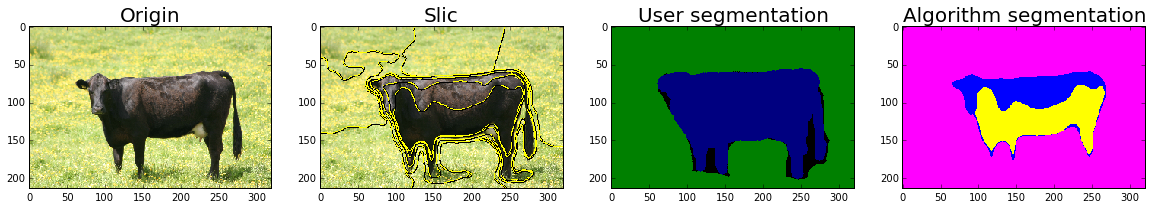

In [153]:
segmentate_by_superpixel_color_sift(test_images[7], test_gt[7], clf_slic_sift, n_superpixels)

[3 3 3 3 3 1 2 3 3 3 3 3]


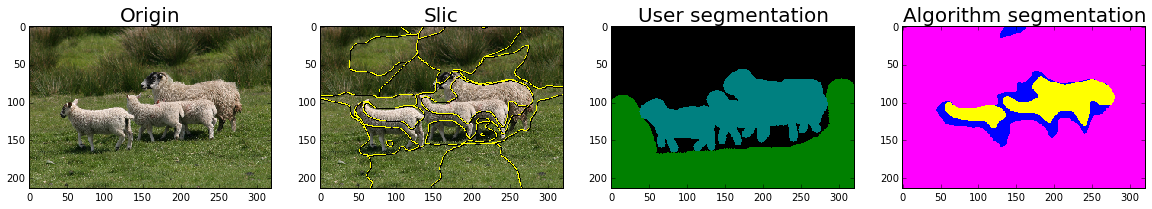

In [154]:
segmentate_by_superpixel_color_sift(test_images[17], test_gt[17], clf_slic_sift, n_superpixels)

[3 2 3 3 2 2 1 3 2 1 2 3]


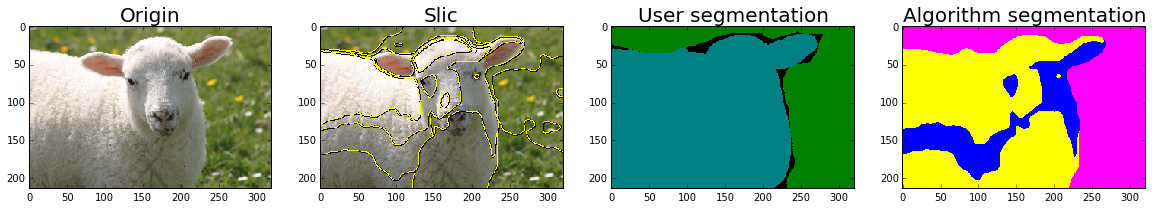

In [155]:
segmentate_by_superpixel_color_sift(test_images[-1], test_gt[-1], clf_slic_sift, n_superpixels)

[3 1 2 3 2 2 1 3 3 3 3 3]


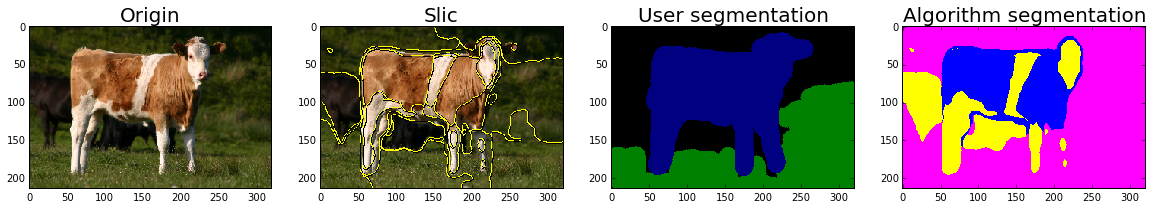

In [156]:
segmentate_by_superpixel_color_sift(test_images[1], test_gt[1], clf_slic_sift, n_superpixels)

[3 3 3 3 3 2 1 1 3 3 3 3]


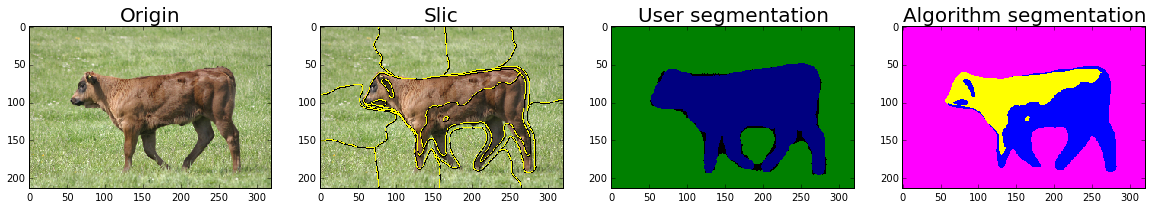

In [157]:
segmentate_by_superpixel_color_sift(test_images[13], test_gt[13], clf_slic_sift, n_superpixels)

В целом результат не изменился

Итак, попиксельная сегментация  дает ожидаемо плохой результат, семгенатция суперписклей сильно все улучшает.